<a href="https://colab.research.google.com/github/iliailmer/harmonic_network/blob/master/skin_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#%%capture
#!pip3 install fastai==0.7.0
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0.post4-{platform}-linux_x86_64.whl torchvision
!pip install -q torch==1.0.0 torchvision

import torch

!pip install Pillow==4.0.0
!pip install image
!pip install torchtext==0.2.3

!pip install kaggle

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

#!ln -s ~/.local/bin/kaggle /usr/bin/kaggle
print(f"CUDA is available: {torch.cuda.is_available()}")
torch.cuda.set_device(0)

from google.colab import drive
drive.mount('/content/drive')

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp drive/My\ Drive/kaggle.json ~/.kaggle/
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip skin-cancer-mnist-ham10000.zip

tcmalloc: large alloc 1073750016 bytes == 0x6256a000 @  0x7f082f0e72a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 5.6MB 6.1MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
    100% |████████████████████████████████| 51kB 3.4MB/s 
  Running setup.py bdist_wheel for torchtext ... - done
  Stored in directory: /root/.cache/pip/wheels/42/a6/f4/b267328bde6bb680094a0c173e8e5627ccc99543abded97204
Successfully built torchtext
Download 100%.
CUDA is available: True
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=94731898

In [0]:
%%capture
!mkdir HAM10000_images
!unzip HAM10000_images_part_1.zip -d HAM10000_images
!unzip HAM10000_images_part_2.zip -d HAM10000_images
!rm HAM10000_images_part_1.zip HAM10000_images_part_2.zip

!ls

In [0]:
import pandas as pd
import numpy as np
from scipy import fftpack
from matplotlib import pyplot as plt
import seaborn as sns
import statistics
import albumentations as alb
import os

from skimage import color, io, morphology, feature, segmentation, exposure
from glob import glob
import typing

In [0]:
def rescale(image, mn=0, mx=1):
  return exposure.rescale_intensity(image,out_range=(mn,mx))

def EME(image, window_height=11, window_width=11):
    """
    EME measure for showing image quality based on human visual system.
    For details, see
    Agaian, Sos S., Karen Panetta,
    and Artyom M. Grigoryan.
    "A new measure of image enhancement."
    IASTED International Conference on Signal Processing & Communication.
    Citeseer, 2000.

    :param image: input image, must be single-channel.
    :param window_height: height of the inspecting window
    :param window_width: width of the inspecting window
    :return: A real-valued enhancement measure.
    """
    height, width = image.shape
    # k_1 = np.floor(height/window_height)
    # k_2 = np.floor(width/window_width)
    sum_ = 0
    k = 0
    H = np.int(np.floor(window_height / 2))  # range in height, distance from the center of the window
    W = np.int(np.floor(window_width / 2))  # range in width, same as above
    for row in range(0 + H, height - H + 1, window_height):
        for column in range(0 + W, width - W + 1, window_width):

            window = image[row - H:row + H + 1, column - W:column + W + 1]

            I_max = window.max()
            I_min = window.min()

            D = (I_max + 1) / (I_min + 1)
            if D < 0.02:
                D = 0.02
            k += 1
            sum_ += 20 * np.log(D)
        # sum_k_1 += sum_k_2
        # sum_k_2 = 0

    eme = sum_ / k
    return eme


def EME_color(image):
    """
    Application of EME to color images.
    :param image: color image (multi-channel)
    :return: EME of that image
    """
    emes_ = []
    if image.shape[-1]>1:
        for each in range(image.shape[-1]):
            emes_.append(EME(image[:,:,each]))
    else:
        emes_.append(EME(image))
    return max(emes_)

def alpha_rooting_fourier(image: np.ndarray, alpha: float = 0.9) -> np.ndarray:
    ffted = fftpack.fft2(image)
    abs_ffted = np.absolute(ffted)**alpha
    iffted = fftpack.ifft2(abs_ffted*ffted/sp.absolute(ffted))
    iffted = rescale(np.absolute(iffted), 0, 1)#.astype(int)
    return iffted


In [27]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,1,scalp,2,None
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,1,scalp,2,None
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,1,scalp,2,None
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,1,scalp,2,None
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,1,ear,2,None


In [29]:
!ls

adc.json		    hmnist_28_28_RGB.csv
drive			    hmnist_8_8_L.csv
HAM10000_images_part_1.zip  hmnist_8_8_RGB.csv
HAM10000_images_part_2.zip  sample_data
HAM10000_metadata.csv	    skin-cancer-mnist-ham10000.zip
hmnist_28_28_L.csv


In [31]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}



metadata = pd.read_csv('HAM10000_metadata.csv')
imgs_28_rgb = pd.read_csv('hmnist_28_28_RGB.csv')
labels = imgs_28_rgb['label'].values
diag_by_txt = dict(zip(list(dict(metadata.dx.value_counts()).keys()),
                       list(dict(pd.value_counts(labels)).keys())))
diag_by_label = dict(zip(list(dict(pd.value_counts(labels)).keys()), 
                         list(dict(metadata.dx.value_counts()).keys())))

metadata['sex'] = pd.Categorical(metadata['sex']).codes
metadata['label'] = metadata['dx'].map(diag_by_txt.get)
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('HAM10000_images', '*.jpg'))}
metadata['path'] = metadata['image_id'].map(imageid_path_dict.get)
metadata['image'] = metadata['path'].map(io.imread)
metadata['diag_name'] = metadata['dx'].map(lesion_type_dict.get) 
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path,image,diag_name
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,1,scalp,2,HAM10000_images/ISIC_0027419.jpg,"[[[188, 147, 191], [186, 148, 189], [187, 150,...",Benign keratosis-like lesions
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,1,scalp,2,HAM10000_images/ISIC_0025030.jpg,"[[[25, 15, 23], [25, 14, 22], [25, 14, 22], [2...",Benign keratosis-like lesions
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,1,scalp,2,HAM10000_images/ISIC_0026769.jpg,"[[[186, 128, 140], [188, 128, 136], [183, 126,...",Benign keratosis-like lesions
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,1,scalp,2,HAM10000_images/ISIC_0025661.jpg,"[[[24, 9, 16], [22, 11, 15], [23, 11, 15], [26...",Benign keratosis-like lesions
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,1,ear,2,HAM10000_images/ISIC_0031633.jpg,"[[[122, 80, 102], [124, 82, 104], [127, 83, 10...",Benign keratosis-like lesions


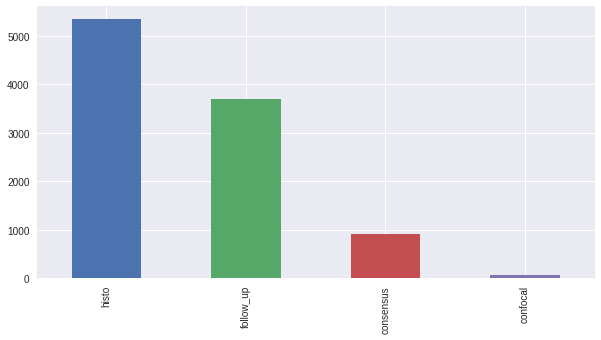

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
metadata['dx_type'].value_counts().plot(kind='bar', ax=ax1)

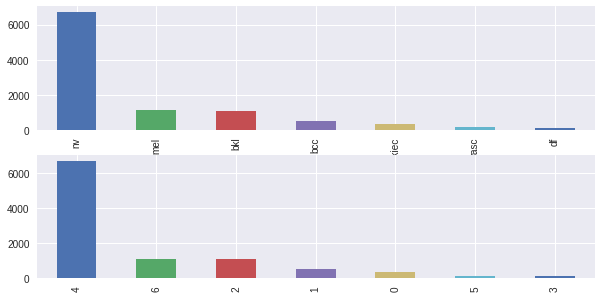

In [9]:
fig, ax = plt.subplots(2, 1, figsize = (10, 5))
metadata['dx'].value_counts().plot(kind='bar', ax=ax[0])
metadata['label'].value_counts().plot(kind='bar', ax=ax[1])

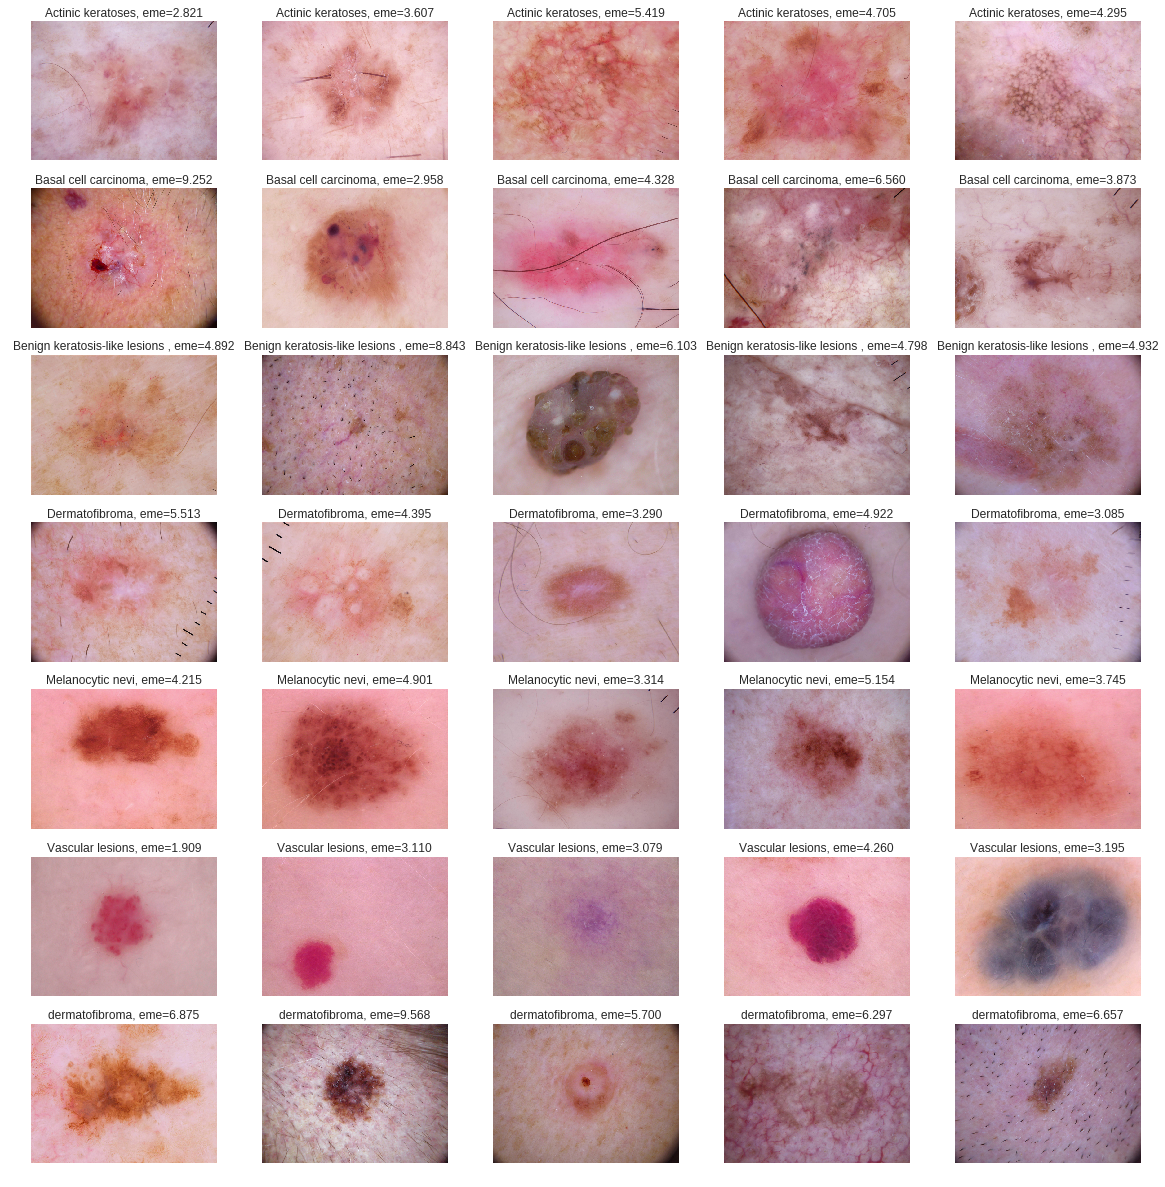

In [10]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         metadata.sort_values(['diag_name']).groupby('diag_name')):
    #n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.grid(False)
        c_ax.imshow(c_row['image'])
        c_ax.set_title(f"{type_name}, eme={EME_color(c_row['image']):.3f}")
        c_ax.axis('off')

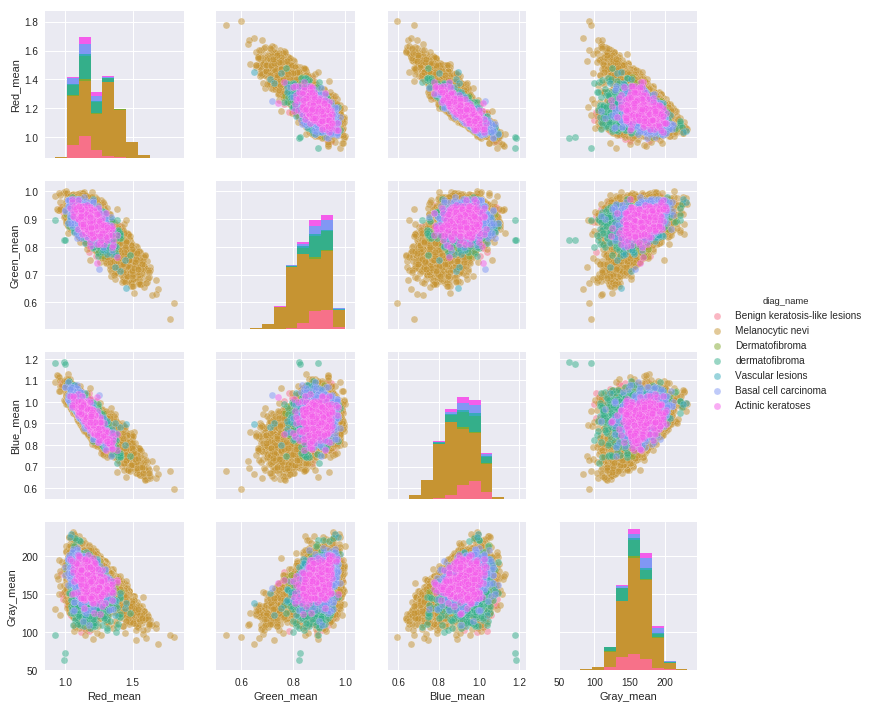

In [13]:
rgb_info_df = metadata.apply(lambda x: pd.Series({'{}_mean'.format(k): v for k, v in 
                                  zip(['Red', 'Green', 'Blue'], 
                                      np.mean(x['image'], (0, 1)))}),1)
gray_col_vec = rgb_info_df.apply(lambda x: np.mean(x), 1)
for c_col in rgb_info_df.columns:
    rgb_info_df[c_col] = rgb_info_df[c_col]/gray_col_vec
rgb_info_df['Gray_mean'] = gray_col_vec
#rgb_info_df.sample(3)

for c_col in rgb_info_df.columns:
    metadata[c_col] = rgb_info_df[c_col].values
    
sns.pairplot(metadata[['Red_mean', 'Green_mean', 'Blue_mean', 'Gray_mean', 'diag_name']], 
             hue='diag_name', plot_kws = {'alpha': 0.5})




In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [0]:
class ConvNet(nn.Module):
  def __init__(self, in_ch, stride, pad):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = in_ch, out_channels = 32, 
                           kernel_size = 5, stride = stride, 
                           padding = pad)
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, 
                           kernel_size = 3, stride = stride, 
                           padding = pad)
    self.fc1 = nn.Linear(in_features = 1024, out_features=128, bias = True)
    self.fc2 = nn.Linear(in_features = 128, out_features = 7, bias = True)
    self.pool = nn.MaxPool2d(kernel_size=3, stride = stride)
    self.dropout = nn.Dropout2d(0.5)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(x)
    x = x.view(-1, 1024)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x
  
model = ConvNet(3, 2, 0)
loss = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [0]:
from sklearn.model_selection import train_test_split
from skimage import io
from skimage import color
class Loader(Dataset):
  def __init__(self, image_name, path, labels, transform = None):
    """
        Args:
            image_name (string): Name of the file in the image
            path (string): Path to the folder with images.
            labels (np.ndarray): labels for images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
    """
    self.data = os.listdir(path)
    self.path = path
    self.name = image_name
    self.labels = labels
    self.transform = transform
  
  def __len__(self):
    return len(self.data) #???
  
  def __getitem__(self):
    image = io.imread(f'{self.path}/{self.name}.jpg')
    label = self.labels[self.data.index(f'{self.name}.jpg')]
    return (image, label)
    
    

In [0]:
loader = Loader()

In [21]:
l = [1,2,3]

l.index(3)

2